In [1]:
import torch
from load_data import *

In [2]:
device = torch.device('cuda:0')

# LoadDataset

In [3]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_german_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

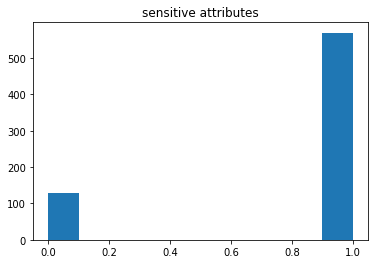

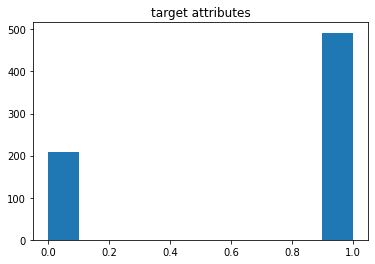

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [6]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.18571429]
training default:  [0.29714286]
test default:  [0.30666667]
# training samples: (700, 23)
# test samples: (300, 23)
# sensitive vars (700, 1)
# output vars (700, 1)


In [26]:
N1 = 300
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [27]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.18571429]
training init:  [0.30333333]
select init:  [0.2925]
test default:  [0.30666667]


In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [29]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [30]:
class Args:
    def __init__(self):
        self.epochs = 50
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [31]:
args = Args()

In [32]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)

In [33]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [34]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [35]:
from fairAL_utils import *

In [36]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=23, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [37]:
for i,(x,y,_) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
#     print(clf(x)[:,0]>0.5)
#     print(sum(y[:,0]==1).float()/y.size(0),y.size(0),sum(y[:,0]==1).float())
    if i>1:
        break

## compute gradient

In [38]:
clf.eval()

Classifier(
  (network): Sequential(
    (0): Linear(in_features=23, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

- adversarial example jacobiab: https://github.com/ast0414/adversarial-example/blob/master/craft.py
- https://github.com/HIPS/autograd
- https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa 

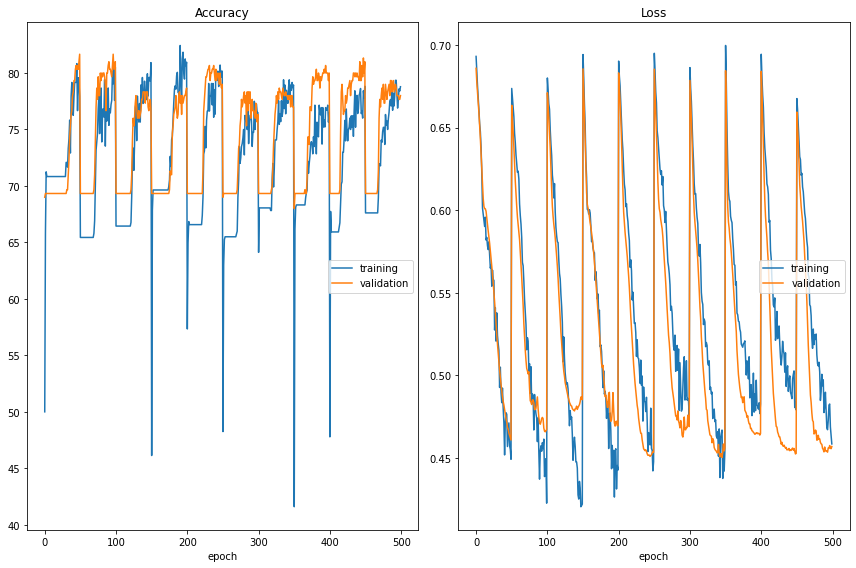

Accuracy
	training         	 (min:   41.595, max:   82.440, cur:   78.788)
	validation       	 (min:   68.000, max:   81.667, cur:   78.000)
Loss
	training         	 (min:    0.420, max:    0.700, cur:    0.458)
	validation       	 (min:    0.450, max:    0.686, cur:    0.457)
Finished Training


In [39]:
clf,f_train,f_select = train_AL_valid(train_loader, select_loader, device, args, test_loader, clf_type = 'NN',\
                                      from_scratch = True, sel_method = 'entropy',val_ratio = 0.2)

In [40]:
clf_criterion = nn.BCELoss()
print("test performances")
test_groupwise(clf,test_loader, clf_criterion, device,args)
print(test_model(clf, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.6162230372428894 / acc 68.33333587646484
1.0 : loss 0.4170723557472229 / acc 80.41666412353516
(tensor(0.4569), tensor(78.))


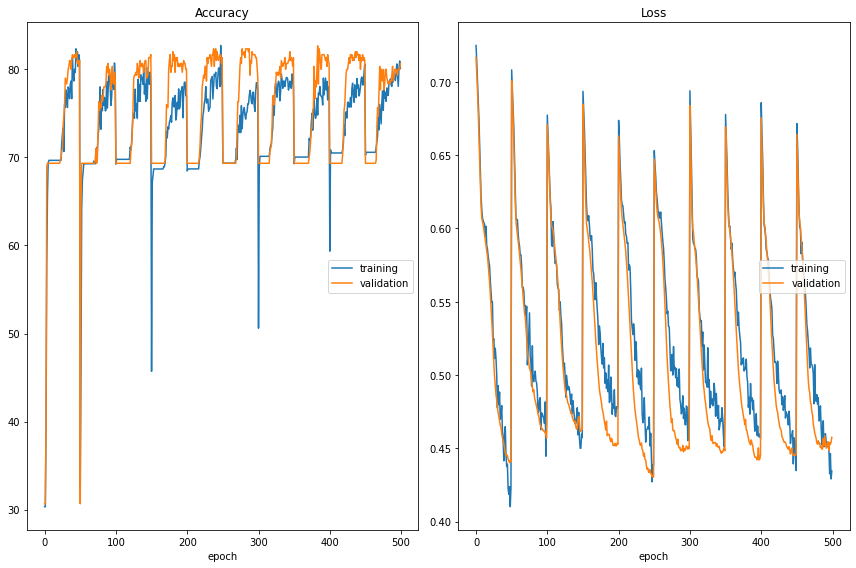

Accuracy
	training         	 (min:   30.333, max:   82.710, cur:   80.102)
	validation       	 (min:   30.667, max:   82.667, cur:   80.667)
Loss
	training         	 (min:    0.410, max:    0.725, cur:    0.434)
	validation       	 (min:    0.430, max:    0.717, cur:    0.457)
Finished Training


In [41]:
clf2,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, clf_type = 'NN',\
                    sel_method = 'random')

In [25]:
clf_criterion = nn.BCELoss()
print("test performances")
test_groupwise(clf2,test_loader, clf_criterion, device,args)
print(test_model(clf2, test_loader, clf_criterion, device))

test performances
0.0 : loss 0.5638844966888428 / acc 73.33333587646484
1.0 : loss 0.4516904950141907 / acc 78.75
(tensor(0.4741), tensor(77.6667))
